In [1]:
import numpy as np

# Load the paired dataset from the .npy file
paired_dataset = np.load('D:SDP/IF Paired/data/train_input.npy')

# Separate CT and MRI images
num_images = paired_dataset.shape[0]
num_ct_images = num_images // 2

ct_images = paired_dataset[:num_ct_images]
mri_images = paired_dataset[num_ct_images:]

# Check the shapes of the loaded data
print("CT images shape:", ct_images.shape)
print("MRI images shape:", mri_images.shape)


CT images shape: (285, 256, 256)
MRI images shape: (285, 256, 256)


In [2]:
test_data = np.load('D:/SDP/IF Paired/data/test_input.npy')
val_data = np.load('D:/SDP/IF Paired/data/val_input.npy')

# Separate CT and MRI images from test dataset
half_length_test = test_data.shape[0] // 2
test_ct_images = test_data[:half_length_test]
test_mri_images = test_data[half_length_test:]

# Separate CT and MRI images from validation dataset
half_length_val = val_data.shape[0] // 2
val_ct_images = val_data[:half_length_val]
val_mri_images = val_data[half_length_val:]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

# Assuming ct_images and mri_images are your training data
# Assuming test_ct_images, test_mri_images are your test data
# Assuming val_ct_images, val_mri_images are your validation data

# 1. Preprocess the data
ct_images = ct_images / 255.0
mri_images = mri_images / 255.0
test_ct_images = test_ct_images / 255.0
test_mri_images = test_mri_images / 255.0
val_ct_images = val_ct_images / 255.0
val_mri_images = val_mri_images / 255.0

# 2. Design the model architecture
def fusion_model():
    inputs_ct = Input(shape=(256, 256, 1))
    inputs_mri = Input(shape=(256, 256, 1))
    
    # Convolutional layers for CT image
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_ct)
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_ct)
    
    # Convolutional layers for MRI image
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_mri)
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_mri)
    
    # Concatenate features
    concat = Concatenate()([conv_ct, conv_mri])
    
    # Fusion layer
    fusion = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat)
    
    model = Model(inputs=[inputs_ct, inputs_mri], outputs=fusion)
    return model

# Define VGG19 model outside of tf.function
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False
model_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
model_vgg.trainable = False

@tf.function
def perceptual_loss(y_true, y_pred):
    # Expand dimensions of grayscale images to match VGG input shape
    y_true_rgb = K.repeat_elements(K.expand_dims(y_true, axis=-1), 3, axis=-1)
    y_pred_rgb = K.repeat_elements(K.expand_dims(y_pred, axis=-1), 3, axis=-1)
    
    true_features = model_vgg(y_true_rgb)
    pred_features = model_vgg(y_pred_rgb)
    
    return K.mean(K.square(true_features - pred_features))

model = fusion_model()
model.compile(optimizer=Adam(), loss=perceptual_loss)

# 3. Train the model
model.fit([ct_images, mri_images], np.zeros_like(ct_images), epochs=10, batch_size=16, validation_data=([val_ct_images, val_mri_images], np.zeros_like(val_ct_images)))

# 4. Evaluate the model
test_loss = model.evaluate([test_ct_images, test_mri_images], np.zeros_like(test_ct_images))

print("Test Loss:", test_loss)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - loss: 0.0010 - val_loss: 9.6814e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - loss: 9.2394e-04 - val_loss: 7.6777e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 155s 9s/step - loss: 7.1563e-04 - val_loss: 5.2470e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - loss: 4.5858e-04 - val_loss: 3.0716e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 155s 9s/step - loss: 2.4996e-04 - val_loss: 9.5884e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - loss: 6.4816e-05 - val_loss: 1.1271e-05
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 155s 9s/step - loss: 7.9232e-06 - val_loss: 3.0143e-06
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - loss: 2.5675e-06 - val_loss: 1.6857e-06
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 160s 9s/step - loss: 1.5473e-06 - val_loss: 1.2161e-06
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - loss: 1.1438e-06 - val_loss: 9.5308e-07
3/3 ━━━━━━━━━━━━━━━━━━

In [5]:
# After training the model
model.save("fusion_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


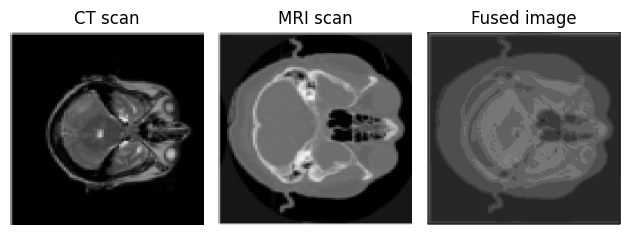

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model("fusion_model.keras", compile=False)

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, color_mode="grayscale", target_size=(256, 256))
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0
    return img_array

def predict_fused_image(ct_img_path, mri_img_path):
    # Preprocess the CT and MRI images
    ct_img = preprocess_image(ct_img_path)
    mri_img = preprocess_image(mri_img_path)
    # Predict the fused image
    fused_img = model.predict([ct_img, mri_img])
    # Denormalize the image
    fused_img = fused_img * 255.0
    # Convert to uint8
    fused_img = np.uint8(fused_img[0])
    return fused_img

# Paths to CT and MRI images
ct_image_path = "D:/SDP/Imfusion-main/screenshots/medical1.png"
mri_image_path = "D:/SDP/Imfusion-main/screenshots/medical2.png"

# Predict the fused image
fused_image = predict_fused_image(ct_image_path, mri_image_path)

# Display the images
import matplotlib.pyplot as plt

# Load and display CT image
ct_image = image.load_img(ct_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 1)
plt.imshow(ct_image, cmap='gray')
plt.title("CT scan")
plt.axis('off')

# Load and display MRI image
mri_image = image.load_img(mri_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 2)
plt.imshow(mri_image, cmap='gray')
plt.title("MRI scan")
plt.axis('off')

# Display the fused image
plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title("Fused image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("image_fusion_model.keras", compile=False)

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, color_mode="grayscale", target_size=(256, 256))
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0
    return img_array

def predict_fused_image(ct_img_path, mri_img_path):
    # Preprocess the CT and MRI images
    ct_img = preprocess_image(ct_img_path)
    mri_img = preprocess_image(mri_img_path)
    # Predict the fused image
    fused_img = model.predict([ct_img, mri_img])
    # Denormalize the image
    fused_img = fused_img * 255.0
    # Convert to uint8
    fused_img = np.uint8(fused_img[0])
    return fused_img

# Paths to CT and MRI images
ct_image_path = "/Users/chintubharath/Documents/sdp/Imfusion-main/demo/medical1.png"
mri_image_path = "/Users/chintubharath/Documents/sdp/Imfusion-main/demo/medical2.png"

# Predict the fused image
fused_image = predict_fused_image(ct_image_path, mri_image_path)

# Load and display CT image
ct_image = image.load_img(ct_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 1)
plt.imshow(ct_image, cmap='gray')
plt.title("CT scan")
plt.axis('off')

# Load and display MRI image
mri_image = image.load_img(mri_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 2)
plt.imshow(mri_image, cmap='gray')
plt.title("MRI scan")
plt.axis('off')

# Display the fused image
plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title("Fused image")
plt.axis('off')

plt.tight_layout()
plt.show()


/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ValueError: Layer 'functional_1' expected 1 input(s). Received 2 instead.